In [104]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from IPython.display import display
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# 1. Import Data
file_path = "D:/Anonymize_Loan_Default_data.csv"
df = pd.read_csv(file_path, encoding='latin1')
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)
    


In [105]:
df.info(verbose=True, show_counts=True, max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38480 non-null  int64  
 1   member_id               38480 non-null  int64  
 2   loan_amnt               38479 non-null  float64
 3   funded_amnt             38479 non-null  float64
 4   funded_amnt_inv         38479 non-null  float64
 5   term                    38480 non-null  object 
 6   int_rate                38480 non-null  float64
 7   installment             38479 non-null  float64
 8   emp_length              37487 non-null  object 
 9   home_ownership          38480 non-null  object 
 10  annual_inc              38478 non-null  float64
 11  verification_status     38480 non-null  object 
 12  issue_d                 38480 non-null  object 
 13  loan_status             38480 non-null  object 
 14  purpose                 38480 non-null

In [106]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
count,3.848000e+04,3.848000e+04,38479.000000,38479.000000,38479.000000,38480.00000,38479.000000,3.847800e+04,38480.000000,38479.000000,38479.000000,14117.000000,38479.000000,38479.000000,3.847600e+04,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38480.000000
mean,6.649979e+05,8.261899e+05,11094.727644,10831.856337,10150.141518,12.16430,323.163255,6.899531e+04,13.378119,0.151927,1.083942,35.009846,9.342966,0.057902,1.428987e+04,22.108501,11980.696892,11274.519569,9646.412705,2232.768235,2614.441757,0.151481
std,2.192322e+05,2.793531e+05,7405.416042,7146.853682,7128.026828,3.73744,209.089097,6.447639e+04,6.744356,0.507592,1.534814,22.426843,4.498075,0.245707,2.194138e+04,11.588602,9006.505205,8946.229941,7051.828302,2570.177312,4391.969583,0.358522
min,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.983645e+05,6.384620e+05,5200.000000,5100.000000,4950.000000,9.62000,165.740000,4.000000e+04,8.200000,0.000000,0.000000,17.000000,6.000000,0.000000,3.639750e+03,13.000000,5463.099238,4811.735000,4400.000000,657.700000,212.010000,0.000000
50%,6.443195e+05,8.242545e+05,9750.000000,9600.000000,8495.792749,11.99000,277.980000,5.865000e+04,13.485000,0.000000,1.000000,33.000000,9.000000,0.000000,8.839500e+03,20.000000,9673.221341,8953.240000,8000.000000,1335.090000,526.000000,0.000000
75%,8.265608e+05,1.034706e+06,15000.000000,15000.000000,14000.000000,14.72000,429.350000,8.200000e+04,18.690000,0.000000,2.000000,51.000000,12.000000,0.000000,1.726550e+04,29.000000,16402.394995,15486.925000,13315.100000,2795.020000,3169.815000,0.000000
max,1.077430e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,100.99000,1305.190000,6.000000e+06,100.000000,11.000000,33.000000,120.000000,47.000000,5.000000,1.207359e+06,90.000000,58563.679930,58563.680000,35000.020000,23611.100000,36115.200000,1.000000


In [107]:
# Thống kê số missing theo biến
print(">>> Số lượng missing value theo từng biến (giảm dần):")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]  # chỉ giữ các biến có missing
missing_summary = missing_summary.sort_values(ascending=False)
print(missing_summary)
repay_counts = df['repay_fail'].value_counts().sort_index()
labels = ['Không vỡ nợ (0)', 'Vỡ nợ (1)']
values = repay_counts.values
colors = ['lightgreen', 'salmon']



>>> Số lượng missing value theo từng biến (giảm dần):
next_pymnt_d              35097
mths_since_last_delinq    24363
emp_length                  993
last_pymnt_d                 71
revol_util                   59
revol_bal                     4
last_credit_pull_d            3
annual_inc                    2
loan_amnt                     1
funded_amnt                   1
funded_amnt_inv               1
installment                   1
open_acc                      1
delinq_2yrs                   1
total_acc                     1
pub_rec                       1
inq_last_6mths                1
total_pymnt                   1
total_rec_int                 1
total_rec_prncp               1
total_pymnt_inv               1
last_pymnt_amnt               1
dtype: int64


In [108]:
# Vẽ biểu đồ pie 
fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=values,
        hole=0.3,  
        pull=[0.05, 0.05],  
        marker=dict(colors=colors, line=dict(color='white', width=2)),
        textinfo='percent+value',  
        insidetextorientation='auto'  
    )]
)

fig.update_layout(
    title_text='Tỷ lệ vỡ nợ (repay_fail)',
    height=500,
    width=500
)

fig.show()

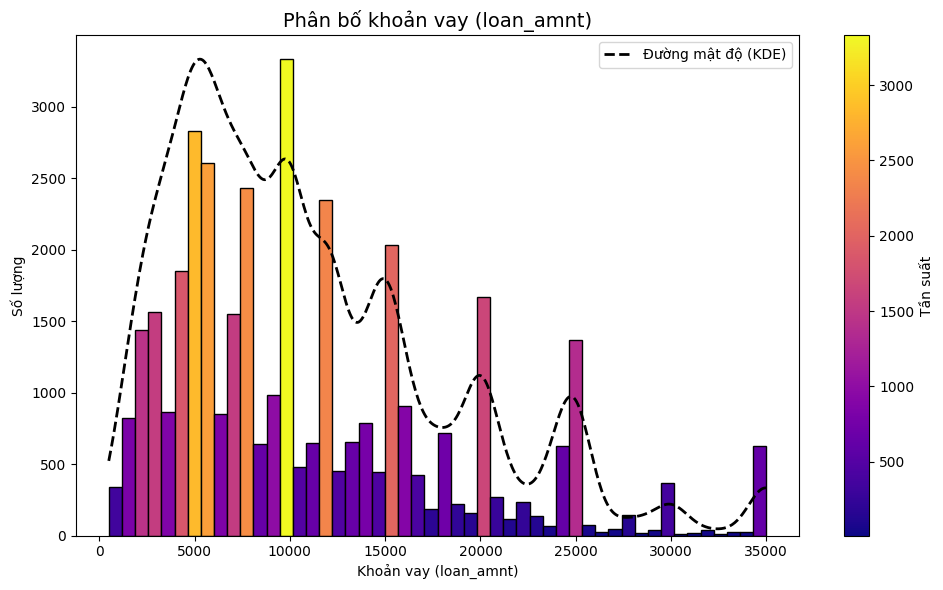

In [109]:
# 2. Loại bỏ các cột không cần thiết hoặc thiếu quá nhiều
drop_cols = ['id', 'member_id', 'issue_d', 'zip_code', 'addr_state',
             'earliest_cr_line', 'mths_since_last_delinq',
             'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'loan_status']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# 3. Loại bỏ Khoản vay NA
df.dropna(subset=['loan_amnt'], inplace=True)
df = df[df['loan_amnt'] != 0]

# Histogram
counts, bins = np.histogram(df['loan_amnt'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

norm = Normalize(vmin=min(counts), vmax=max(counts))
colors = cm.plasma(norm(counts))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bin_centers, counts, width=(bins[1] - bins[0]), color=colors, edgecolor='black')

kde = gaussian_kde(df['loan_amnt'])
x_vals = np.linspace(df['loan_amnt'].min(), df['loan_amnt'].max(), 500)
kde_vals = kde(x_vals)

kde_vals_scaled = kde_vals * max(counts) / max(kde_vals)
ax.plot(x_vals, kde_vals_scaled, color='black', linestyle='--', linewidth=2, label='Đường mật độ (KDE)')

ax.set_title("Phân bố khoản vay (loan_amnt)", fontsize=14)
ax.set_xlabel("Khoản vay (loan_amnt)")
ax.set_ylabel("Số lượng")

sm = cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Tần suất")

ax.legend()
plt.tight_layout()
plt.show()



In [110]:
# 4. Xử lý biến
df['annual_inc'].fillna(df['annual_inc'].median(), inplace=True)
df['revol_bal'].fillna(df['revol_bal'].median(), inplace=True)
df['revol_util'].fillna(0, inplace=True)

emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
           '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
           '10+ years': 10}
df['emp_length_num'] = df['emp_length'].map(emp_map)
df['emp_length_num'].fillna(df['emp_length_num'].median(), inplace=True)
df.drop(columns='emp_length', inplace=True)

df['term'] = df['term'].str.extract('(\d+)').astype(int)

df['revol_util'] = df['revol_util'].astype(str).str.replace('%', '')
df['revol_util'] = df['revol_util'].str.replace(r'[^0-9\.]', '', regex=True)
df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')
df['revol_util'].fillna(0, inplace=True)

<>:13: SyntaxWarning:

invalid escape sequence '\d'

<>:13: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\Vu Pham Thanh Phuong\AppData\Local\Temp\ipykernel_13608\1864799074.py:13: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\Vu Pham Thanh Phuong\AppData\Local\Temp\ipykernel_13608\1864799074.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Vu Pham Thanh Phuong\AppData\Local\Temp\ipykernel_13608\1864799074.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through 

In [111]:
# 5. Mã hóa one-hot các biến phân loại
cat_cols = ['home_ownership', 'verification_status', 'purpose']
df = pd.get_dummies(df, columns=cat_cols,  drop_first=False)

# Ép kiểu bool -> int cho các biến dummy
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

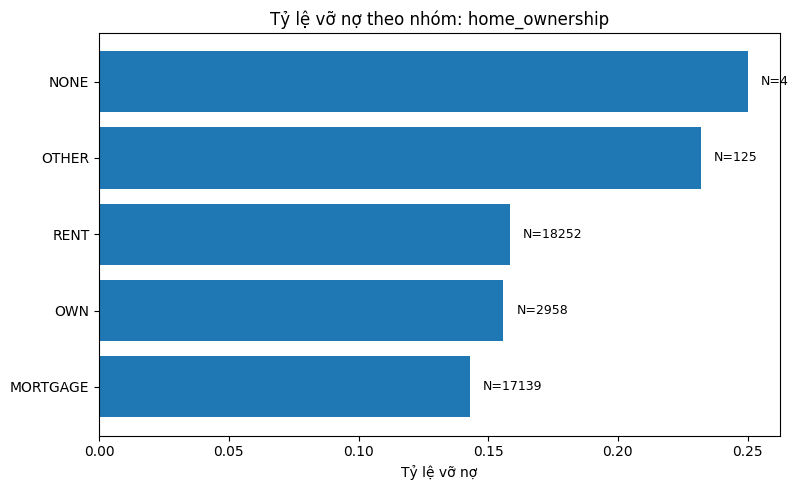

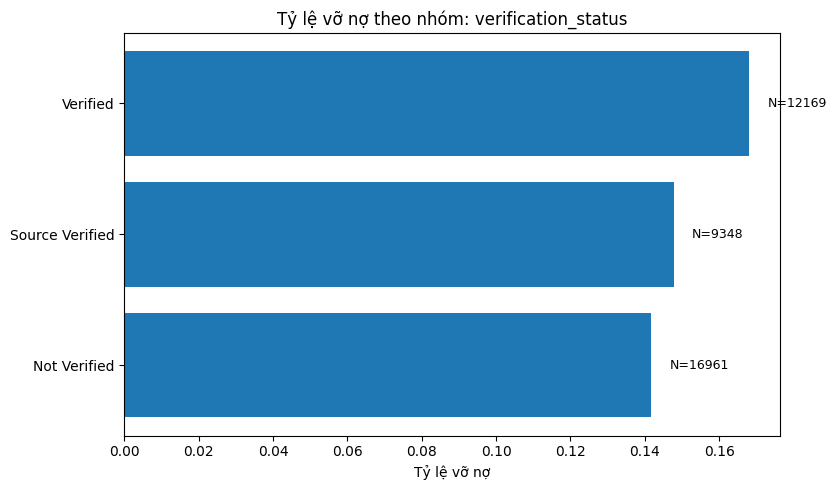

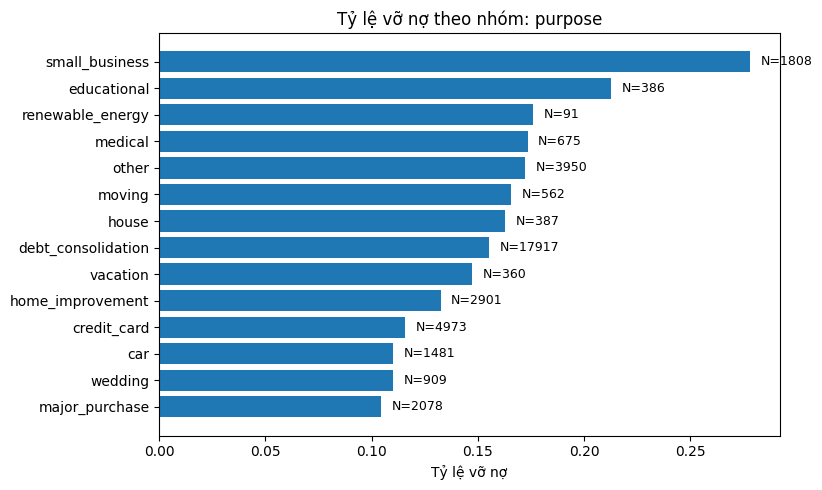

In [112]:
# 6.1. Kiểm tra dummy
def plot_default_rate_per_category(df, base_col):
    # Lấy các cột dummy thuộc biến gốc
    dummy_cols = [col for col in df.columns if col.startswith(base_col + '_')]
    
    stats = []
    for col in dummy_cols:
        group = df[df[col] == 1]
        total = len(group)
        default = group['repay_fail'].sum()
        rate = default / total if total > 0 else 0
        stats.append({
            'category': col.replace(base_col + '_', ''),  
            'total': total,
            'defaults': int(default),
            'default_rate': rate
        })

    stats_df = pd.DataFrame(stats).sort_values(by='default_rate', ascending=False)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    bars = plt.barh(stats_df['category'], stats_df['default_rate'])
    plt.xlabel('Tỷ lệ vỡ nợ')
    plt.title(f'Tỷ lệ vỡ nợ theo nhóm: {base_col}')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    for bar, total in zip(bars, stats_df['total']):
        plt.text(bar.get_width() + 0.005,            
                 bar.get_y() + bar.get_height() / 2,  
                 f'N={total}', va='center', fontsize=9)

    plt.show()
    
    return stats_df


stats_home = plot_default_rate_per_category(df, 'home_ownership')
stats_verification = plot_default_rate_per_category(df, 'verification_status')
stats_purpose = plot_default_rate_per_category(df, 'purpose')


In [113]:
# 6.2. Gộp nhóm Dummy
if all(col in df.columns for col in ['home_ownership_OTHER']):
    df['home_ownership_rare'] = df[['home_ownership_OTHER']].sum(axis=1).clip(upper=1)
else:
    df['home_ownership_rare'] = 0

if all(col in df.columns for col in ['home_ownership_RENT', 'home_ownership_OWN', 'home_ownership_MORTGAGE']):
    df['home_ownership_main'] = df[['home_ownership_RENT', 'home_ownership_OWN', 'home_ownership_MORTGAGE']].sum(axis=1).clip(upper=1)
else:
    df['home_ownership_main'] = 0

purpose_dummies_all = [col for col in df.columns if col.startswith('purpose_')]

purpose_dummies = [col for col in purpose_dummies_all if col not in ['purpose_renewable_energy']]

if 'purpose_small_business' in df.columns:
    df['purpose_small_business_dummy'] = df['purpose_small_business']
else:
    df['purpose_small_business_dummy'] = 0

purpose_other_dummies = [col for col in purpose_dummies if col != 'purpose_small_business']
if purpose_other_dummies:
    df['purpose_other'] = df[purpose_other_dummies].sum(axis=1).clip(upper=1)
else:
    df['purpose_other'] = 0

# In kiểm tra xem đang gộp những cột nào
print("Gộp thành purpose_other từ các cột:")
print(purpose_other_dummies)

home_dummies_to_drop = ['home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_RENT', 'home_ownership_OWN', 'home_ownership_MORTGAGE']
purpose_dummies_to_drop = [col for col in purpose_dummies_all if col not in ['purpose_other', 'purpose_small_business_dummy']]

df.drop(columns=home_dummies_to_drop + purpose_dummies_to_drop, inplace=True)

cols = df.columns.tolist()
for col in ['purpose_other', 'purpose_small_business_dummy']:
    if col in cols:
        cols.remove(col)
        cols.append(col)

df = df[cols]


Gộp thành purpose_other từ các cột:
['purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_vacation', 'purpose_wedding']


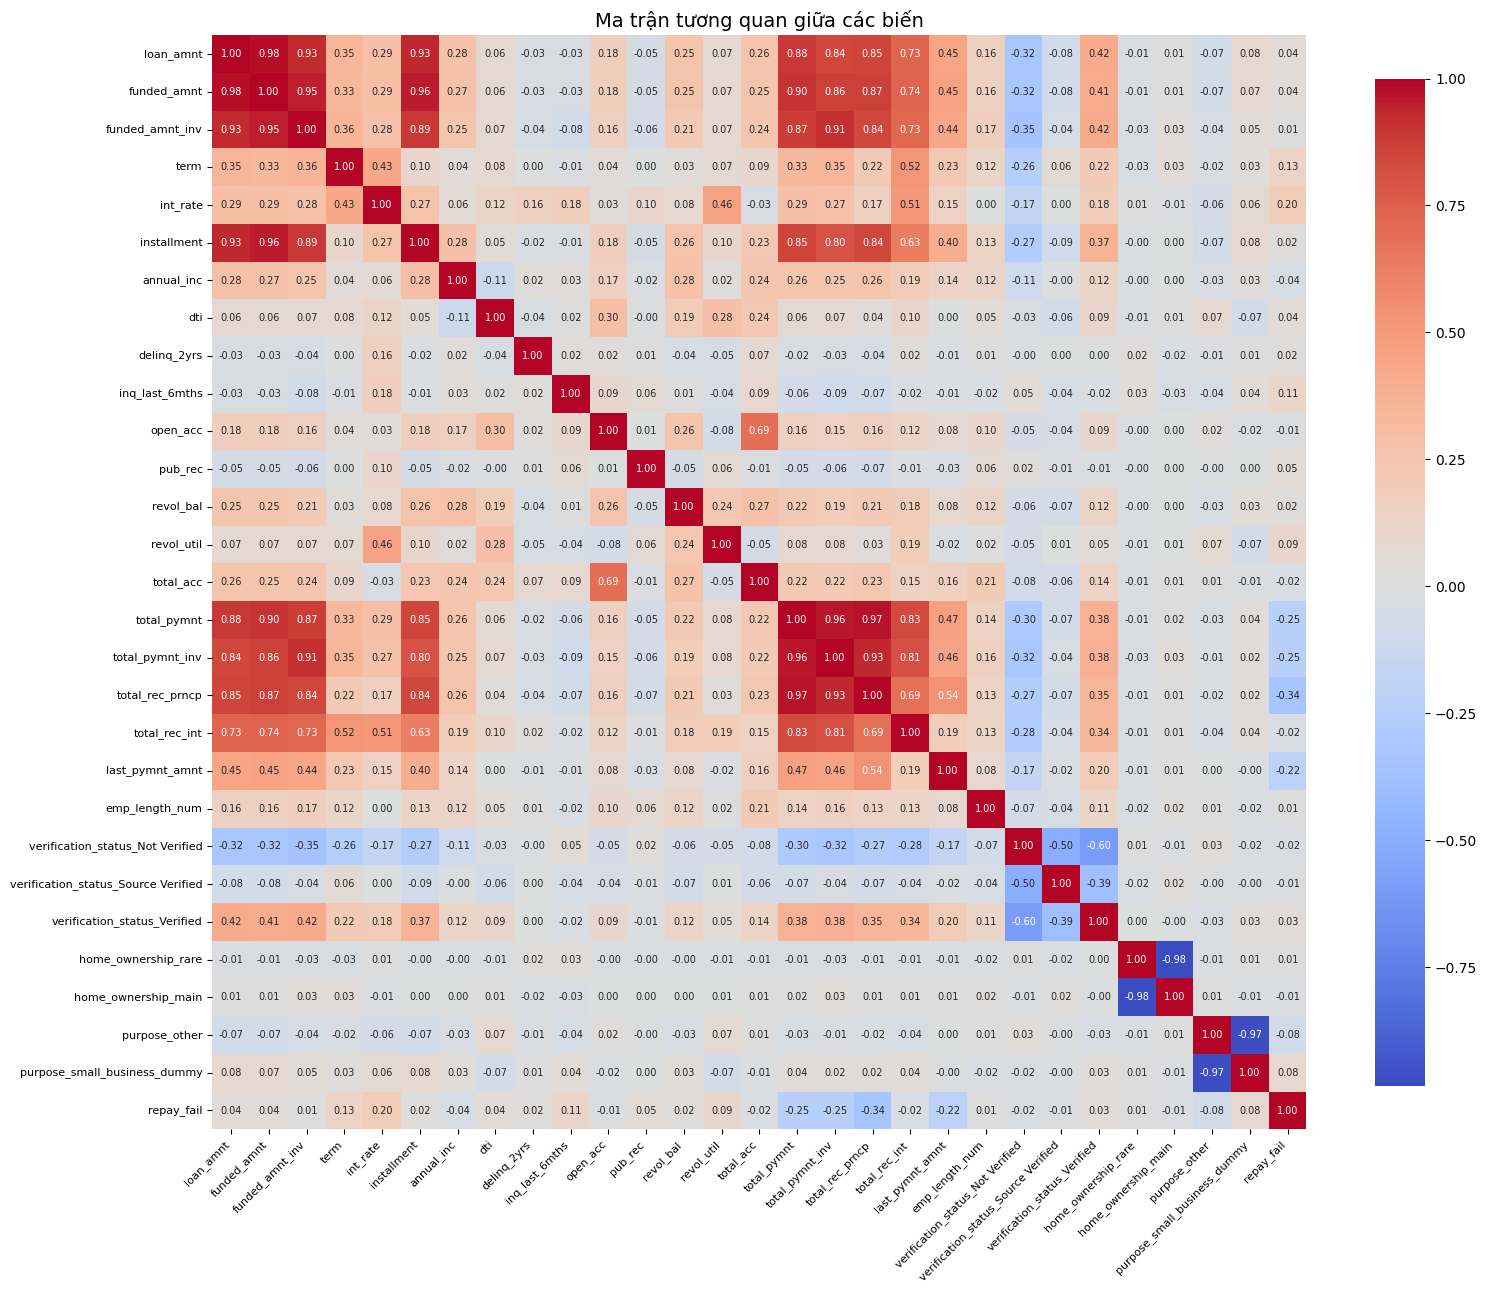

In [114]:
# 7. Corr_Matrix
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()
cols = [col for col in corr_matrix.columns if col != 'repay_fail'] + ['repay_fail']
corr_matrix = corr_matrix.loc[cols, cols]
plt.figure(figsize=(16, 14)) 

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink': .8},
    annot_kws={"size": 7}
)

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.title("Ma trận tương quan giữa các biến", fontsize=14)
plt.tight_layout()
plt.show()

# 8. Loại bỏ các biến gần như trùng lặp
for col in ['funded_amnt_inv', 'total_pymnt_inv']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

df.to_csv("D:/cleaned_loan_data.csv", index=False)



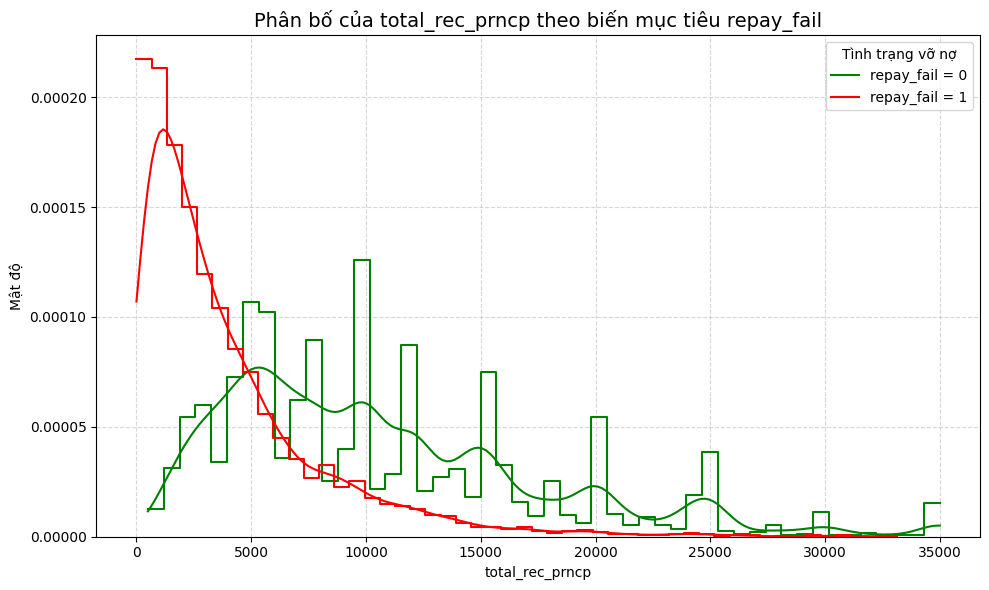

C:\Users\Vu Pham Thanh Phuong\AppData\Local\Temp\ipykernel_13608\4175803614.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




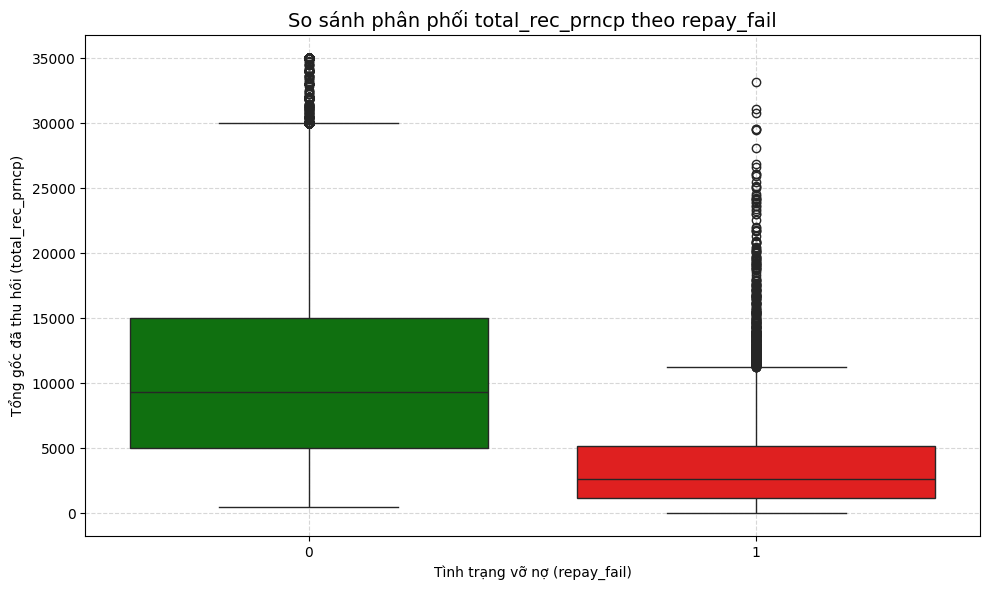

In [115]:
# Vẽ histogram của total_rec_prncp theo repay_fail
plt.figure(figsize=(10, 6))

# Chia nhóm theo repay_fail
for label, color in zip([0, 1], ['green', 'red']):
    subset = df[df['repay_fail'] == label]['total_rec_prncp']
    sns.histplot(subset, 
                 bins=50, 
                 kde=True, 
                 stat='density', 
                 element='step', 
                 fill=False, 
                 label=f"repay_fail = {label}", 
                 color=color)

plt.title("Phân bố của total_rec_prncp theo biến mục tiêu repay_fail", fontsize=14)
plt.xlabel("total_rec_prncp")
plt.ylabel("Mật độ")
plt.legend(title="Tình trạng vỡ nợ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='repay_fail', y='total_rec_prncp', data=df, palette=['green', 'red'])
plt.title("So sánh phân phối total_rec_prncp theo repay_fail", fontsize=14)
plt.xlabel("Tình trạng vỡ nợ (repay_fail)")
plt.ylabel("Tổng gốc đã thu hồi (total_rec_prncp)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

fig = px.histogram(df, 
                   x='total_rec_prncp', 
                   color='repay_fail', 
                   nbins=50,
                   histnorm='percent',
                   barmode='overlay',  
                   color_discrete_map={0: 'green', 1: 'red'})
fig.update_layout(
    title='Phân phối total_rec_prncp theo repay_fail (Plotly)',
    xaxis_title='total_rec_prncp',
    yaxis_title='Tỷ lệ (%)',
    bargap=0.1
)
fig.show()



In [116]:
df.info(verbose=True, show_counts=True, max_cols=None)


<class 'pandas.core.frame.DataFrame'>
Index: 38478 entries, 1 to 38479
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            38478 non-null  float64
 1   funded_amnt                          38478 non-null  float64
 2   term                                 38478 non-null  int64  
 3   int_rate                             38478 non-null  float64
 4   installment                          38478 non-null  float64
 5   annual_inc                           38478 non-null  float64
 6   dti                                  38478 non-null  float64
 7   delinq_2yrs                          38478 non-null  float64
 8   inq_last_6mths                       38478 non-null  float64
 9   open_acc                             38478 non-null  float64
 10  pub_rec                              38478 non-null  float64
 11  revol_bal                        

In [117]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
loan_amnt,38478.0,11095.015983,7405.296268,500.00,5200.000000,9750.000000,15000.000000,3.500000e+04
funded_amnt,38478.0,10832.137845,7146.733214,500.00,5100.000000,9600.000000,15000.000000,3.500000e+04
term,38478.0,42.166225,10.486655,36.00,36.000000,36.000000,60.000000,6.000000e+01
int_rate,38478.0,12.162307,3.709485,5.42,9.620000,11.990000,14.720000,2.411000e+01
installment,38478.0,323.171653,209.085323,15.67,165.740000,277.980000,429.350000,1.305190e+03
annual_inc,38478.0,68996.833164,64475.450872,1896.00,40000.000000,58650.000000,82000.000000,6.000000e+06
dti,38478.0,13.376215,6.729713,0.00,8.200000,13.485000,18.690000,2.999000e+01
delinq_2yrs,38478.0,0.151931,0.507598,0.00,0.000000,0.000000,0.000000,1.100000e+01
inq_last_6mths,38478.0,1.083970,1.534824,0.00,0.000000,1.000000,2.000000,3.300000e+01
open_acc,38478.0,9.343209,4.497881,1.00,6.000000,9.000000,12.000000,4.700000e+01


In [118]:
numeric_cols = [col for col in df.columns 
                if df[col].dtype in [float, int] 
                and not str(df[col].dtype).startswith('uint') 
                and col != 'repay_fail' 
                and df[col].nunique() > 10]  # Loại biến 0/1

# Hàm kiểm tra outlier theo IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

outlier_report = []
for col in numeric_cols:
    out_count, low, high = detect_outliers_iqr(df, col)
    outlier_report.append({
        'Variable': col,
        'Outlier Count': out_count,
        'Lower Bound': round(low, 2),
        'Upper Bound': round(high, 2),
        'Total Observations': df[col].shape[0],
        'Outlier Ratio (%)': round(100 * out_count / df[col].shape[0], 2)
    })

outlier_df = pd.DataFrame(outlier_report)
outlier_df = outlier_df.sort_values(by='Outlier Ratio (%)', ascending=False)

display(outlier_df.head(20))  


,Variable,Outlier Count,Lower Bound,Upper Bound,Total Observations,Outlier Ratio (%)
6,delinq_2yrs,4278,0.00,0.00,38478,11.12
15,last_pymnt_amnt,4239,-4224.86,7606.86,38478,11.02
14,total_rec_int,3026,-2548.36,6001.21,38478,7.86
9,revol_bal,2624,-16796.50,37701.50,38478,6.82
4,annual_inc,1844,-23000.00,145000.00,38478,4.79
12,total_pymnt,1266,-10946.09,32811.94,38478,3.29
3,installment,1232,-229.68,824.77,38478,3.20
0,loan_amnt,1103,-9500.00,29700.00,38478,2.87
1,funded_amnt,931,-9750.00,29850.00,38478,2.42
13,total_rec_prncp,930,-8976.27,26693.79,38478,2.42



======================= TỶ LỆ 70/30 =======================

--- Logistic Regression ---


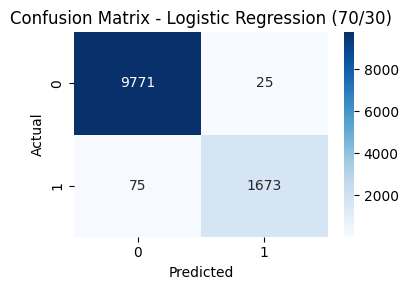

              precision  recall  f1-score    support
0                 0.992   0.997     0.995   9796.000
1                 0.985   0.957     0.971   1748.000
accuracy          0.991   0.991     0.991      0.991
macro avg         0.989   0.977     0.983  11544.000
weighted avg      0.991   0.991     0.991  11544.000

--- Neural Network ---


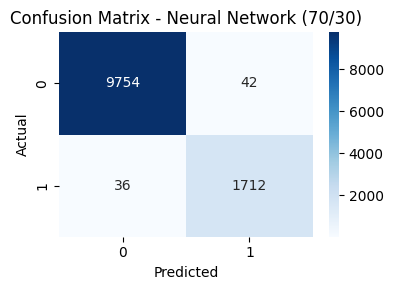

              precision  recall  f1-score    support
0                 0.996   0.996     0.996   9796.000
1                 0.976   0.979     0.978   1748.000
accuracy          0.993   0.993     0.993      0.993
macro avg         0.986   0.988     0.987  11544.000
weighted avg      0.993   0.993     0.993  11544.000

--- Random Forest ---


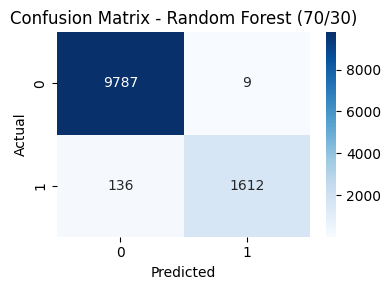

              precision  recall  f1-score    support
0                 0.986   0.999     0.993   9796.000
1                 0.994   0.922     0.957   1748.000
accuracy          0.987   0.987     0.987      0.987
macro avg         0.990   0.961     0.975  11544.000
weighted avg      0.988   0.987     0.987  11544.000

--- XGBoost ---


c:\Users\Vu Pham Thanh Phuong\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[02:28:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




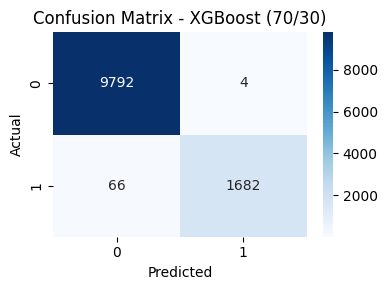

              precision  recall  f1-score    support
0                 0.993   1.000     0.996   9796.000
1                 0.998   0.962     0.980   1748.000
accuracy          0.994   0.994     0.994      0.994
macro avg         0.995   0.981     0.988  11544.000
weighted avg      0.994   0.994     0.994  11544.000


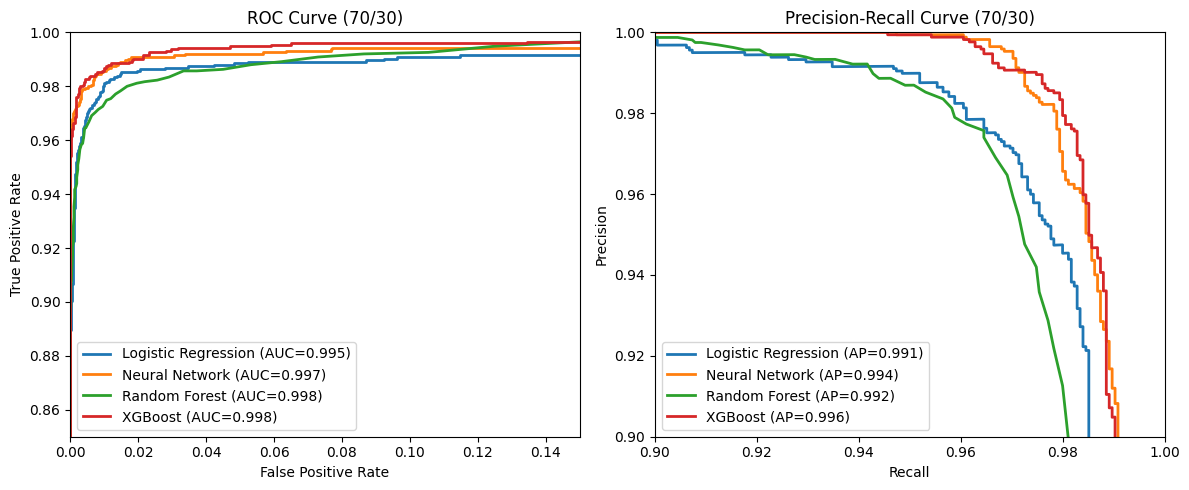


======================= TỶ LỆ 80/20 =======================

--- Logistic Regression ---


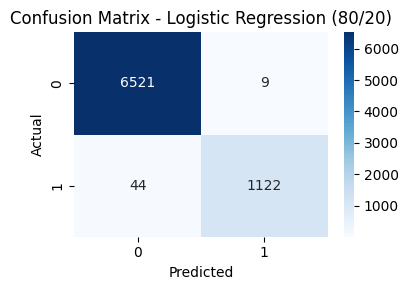

              precision  recall  f1-score   support
0                 0.993   0.999     0.996  6530.000
1                 0.992   0.962     0.977  1166.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.993   0.980     0.986  7696.000
weighted avg      0.993   0.993     0.993  7696.000

--- Neural Network ---


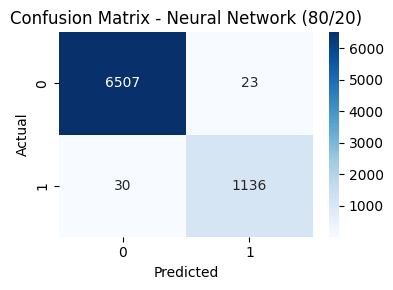

              precision  recall  f1-score   support
0                 0.995   0.996     0.996  6530.000
1                 0.980   0.974     0.977  1166.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.988   0.985     0.987  7696.000
weighted avg      0.993   0.993     0.993  7696.000

--- Random Forest ---


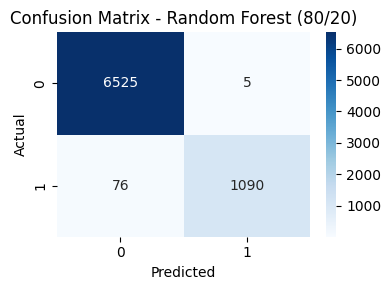

              precision  recall  f1-score   support
0                 0.988   0.999     0.994  6530.000
1                 0.995   0.935     0.964  1166.000
accuracy          0.989   0.989     0.989     0.989
macro avg         0.992   0.967     0.979  7696.000
weighted avg      0.990   0.989     0.989  7696.000

--- XGBoost ---


c:\Users\Vu Pham Thanh Phuong\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[02:29:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




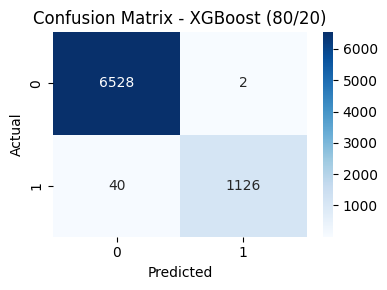

              precision  recall  f1-score   support
0                 0.994   1.000     0.997  6530.000
1                 0.998   0.966     0.982  1166.000
accuracy          0.995   0.995     0.995     0.995
macro avg         0.996   0.983     0.989  7696.000
weighted avg      0.995   0.995     0.995  7696.000


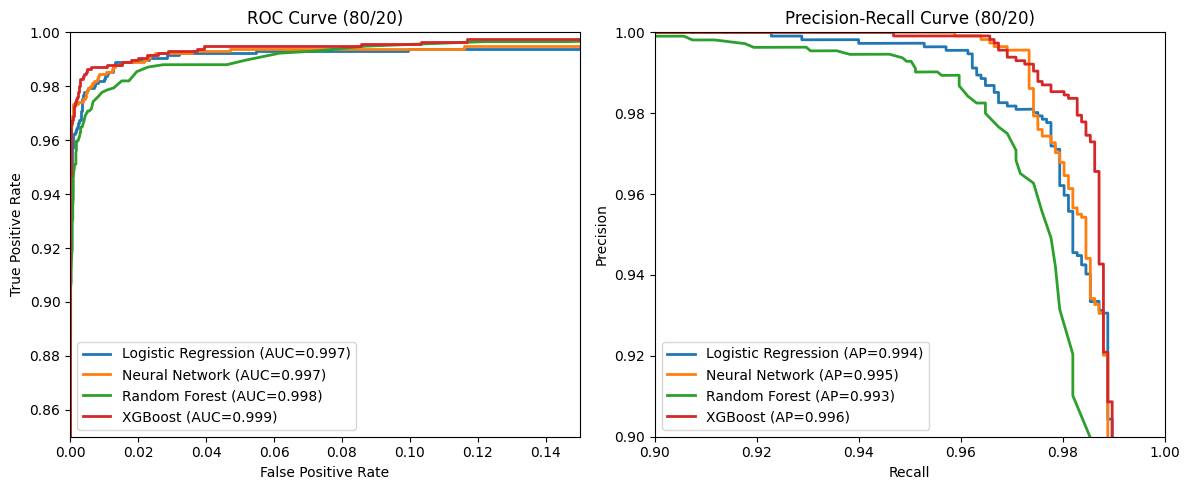

In [119]:
# Tách biến mục tiêu 
X = df.drop(columns='repay_fail')
y = df['repay_fail']

# Xác định danh sách dummy để KHÔNG scale 
dummy_cols = [col for col in X.columns if X[col].dropna().isin([0, 1]).all()]
continuous_cols = [col for col in X.columns if col not in dummy_cols and X[col].nunique() > 10]

summary_results = {"70/30": [], "80/20": []}
ratios = [(0.3, "70/30"), (0.2, "80/20")]

for test_size, label in ratios:
    print(f"\n======================= TỶ LỆ {label} =======================")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # RobustScaler
    scaler = RobustScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
    X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

    # SMOTE 
    smote = SMOTE(random_state=42)
    X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train)
    X_train_smote_unscaled, y_train_smote_unscaled = smote.fit_resample(X_train, y_train)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    y_score_dict = {}

    for name, model in models.items():
        print(f"\n--- {name} ---")

        if name in ["Logistic Regression", "Neural Network"]:
            model.fit(X_train_smote_scaled, y_train_smote_scaled)
            y_pred = model.predict(X_test_scaled)
            X_test_input = X_test_scaled
        else:
            model.fit(X_train_smote_unscaled, y_train_smote_unscaled)
            y_pred = model.predict(X_test)
            X_test_input = X_test

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name} ({label})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        # Classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        print(pd.DataFrame(report).transpose().round(3))

        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_input)[:, 1]
        else:
            y_score = model.decision_function(X_test_input)
        y_score_dict[name] = y_score

        auc_score = roc_auc_score(y_test, y_score)
        ap_score = average_precision_score(y_test, y_score)

        summary_results[label].append({
            "Model": name,
            "Accuracy": report['accuracy'],
            "Precision": report['1']['precision'],
            "Recall": report['1']['recall'],
            "F1-Score": report['1']['f1-score'],
            "AUC": auc_score,
            "AP": ap_score
        })

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for name, y_score in y_score_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_score = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 0.15])    
    plt.ylim([0.85, 1.00])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({label})')
    plt.legend()

    # Precision-Recall
    plt.subplot(1, 2, 2)
    for name, y_score in y_score_dict.items():
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f'{name} (AP={ap:.3f})', linewidth=2)
    plt.xlim([0.90, 1.00])
    plt.ylim([0.90, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({label})')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [120]:
# Tổng hợp bảng kết quả
for ratio_label, results in summary_results.items():
    print(f"\n===== BẢNG TỔNG HỢP KẾT QUẢ ({ratio_label}) =====")
    summary_df = pd.DataFrame(results)
    print(summary_df.round(3))



===== BẢNG TỔNG HỢP KẾT QUẢ (70/30) =====
                 Model  Accuracy  Precision  Recall  F1-Score    AUC     AP
0  Logistic Regression     0.991      0.985   0.957     0.971  0.995  0.991
1       Neural Network     0.993      0.976   0.979     0.978  0.997  0.994
2        Random Forest     0.987      0.994   0.922     0.957  0.998  0.992
3              XGBoost     0.994      0.998   0.962     0.980  0.998  0.996

===== BẢNG TỔNG HỢP KẾT QUẢ (80/20) =====
                 Model  Accuracy  Precision  Recall  F1-Score    AUC     AP
0  Logistic Regression     0.993      0.992   0.962     0.977  0.997  0.994
1       Neural Network     0.993      0.980   0.974     0.977  0.997  0.995
2        Random Forest     0.989      0.995   0.935     0.964  0.998  0.993
3              XGBoost     0.995      0.998   0.966     0.982  0.999  0.996
